# TMA4205 project part 2 - Ottar Hellan

The multigrid methods are implemented in the attached python file ```multigrid.py```.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from multigrid import *
from time import time

## 1
For this project we have implemented a tailored conjugate gradient method specifically for the 2D unit square Poisson problem that works directly on the grid. This CG-method is an integral part to the multigrid method we later develop. 

We test our homemade CG-method on the test problem
\begin{align*}
    -\nabla^2 u & = f = 20\pi^2 \sin(2\pi x) \sin(4\pi y), \, \text{ on } \Omega = (0,1)\times(0,1) \\
    u & = g = \sin(2\pi x) \sin(4\pi y),\text{ on } \partial\Omega.
\end{align*}
Simple calculations confirm that $u = g$ on $\Omega$ is a solution of this problem.

#Iterations = 451


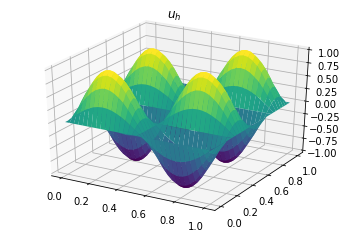

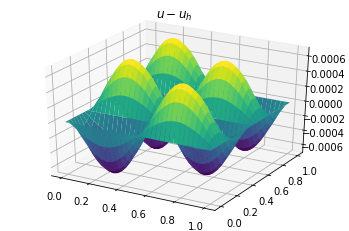

In [25]:
f = lambda x, y: 20*np.pi**2 * np.sin(2*np.pi*x) * np.sin(4*np.pi*y)
g = lambda x, y: np.sin(2*np.pi*x) * np.sin(4*np.pi*y)
u_ex = lambda x, y: np.sin(2*np.pi*x) * np.sin(4*np.pi*y)
#fp = lambda x, y: 2*x**2 - 2*x + 2*y**2 - 2*y
#f = lambda x, y: 20*fp(x,y)
#g = lambda x, y: 0*x*y
#u_exp = lambda x, y: (x-x**2) * (y-y**2)
#u_ex = lambda x, y: 20*u_exp(x,y)


N = 2**7

x = np.outer(np.linspace(0, 1, N+1), np.ones(N+1))
y = np.outer(np.ones(N+1), np.linspace(0, 1, N+1))

b = g(x, y)
b[1:-1, 1:-1] = f(x[1:-1, 1:-1], y[1:-1, 1:-1])


u0 = g(x, y)
np.random.seed(seed=1)
u0[1:-1, 1:-1] = 1 - 0.5*np.random.random((N-1,N-1))

s = 1
u, i = my_cg(u0, b, N, max_iter=1000)

print(f'#Iterations = {i}')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

s = 4
surf = ax.plot_surface(x[::s,::s], y[::s,::s], u[::s,::s],
                        rstride=1, cstride=1, 
                        cmap=matplotlib.cm.viridis)
plt.title('$u_h$')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

s = 4
surf = ax.plot_surface(x[::s,::s], y[::s,::s], (u_ex(x,y) - u)[::s,::s],
                        rstride=1, cstride=1, 
                        cmap=matplotlib.cm.viridis)
plt.title('$u - u_h$');


## 3
Comparing the conjugate gradient method with the preconditioned conjugate gradient method, using our V-cycle multigrid as preconditioner.

Test problem defined by:
\begin{align*}
    -\nabla^2 u & = f = -1, \text{ on } \Omega = (0,1)\times(0,1) \\
    u & = g,\text{ on } \partial\Omega \\
    g(0,y) & = 4\, y\, (1-y), \text{ else } g = 0
\end{align*}

N = 176   

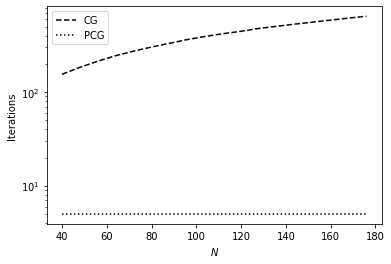

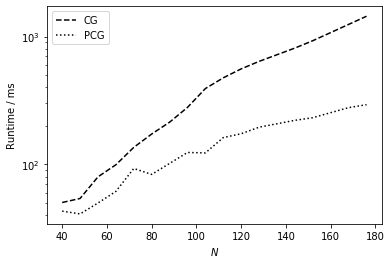

In [21]:
"""
    Comparison of the conjugate gradient and multigrid-preconditioned conjugate gradient
    methods on a simple test problem with constant laplacian and non-homogeneous Dirichlet
    boundary conditions.
"""

f = lambda x, y: 0*x - 1
g = lambda x, y: np.where(x == 0, 4*y*(1-y), 0*x)

cg_iters = []
cg_times = []
pcg_iters = []
pcg_times = []


K = 20
Ns = 2**3 * np.unique(np.logspace(2.5, 4.5, K, base=2.0, dtype=int))
for N in Ns:
    print('\r' + ' '*10 + '\r' + f'N = {N}', end='')

    x = np.outer(np.linspace(0, 1, N+1), np.ones(N+1))
    y = np.outer(np.ones(N+1), np.linspace(0, 1, N+1))

    rhs = g(x, y)
    rhs[1:-1, 1:-1] = f(x[1:-1, 1:-1], y[1:-1, 1:-1])

    np.random.seed(seed=1)
    u0 = np.copy(rhs)
    u0[1:-1,1:-1] = 1 - np.random.random((N-1, N-1))*0.5


    """ Conjugate Gradient """
    tol      = 1e-13
    max_iter = 1000

    start = time()
    uh, i = my_cg(u0, rhs, N, tol=tol, max_iter=max_iter)
    end = time()
    cg_iters.append(i)
    cg_times.append(end - start)


    """ Preconditioned Conjugate Gradient """
    levels     = 4
    nu1        = 10
    nu2        = 10
    tol        = 1e-12
    max_iter   = 1000
    cg_tol     = 1e-12
    cg_maxiter = 1000

    start = time()
    uh, i, ns = pcg(u0, rhs, N, nu1, nu2, level=1, max_level=levels, tol=tol, max_iter=max_iter, cg_tol=cg_tol, cg_maxiter=cg_maxiter)
    end = time()
    pcg_iters.append(i)
    pcg_times.append(end - start)

Ns = np.array(Ns, dtype=int)
cg_iters = np.array(cg_iters, dtype=float)
cg_times = np.array(cg_times, dtype=float)
pcg_iters = np.array(pcg_iters, dtype=float)
pcg_times = np.array(pcg_times, dtype=float)

plt.figure()
plt.semilogy(Ns, cg_iters, 'k--', label='CG')
plt.semilogy(Ns, pcg_iters, 'k:', label='PCG')
plt.ylabel('Iterations')
plt.xlabel('$N$')
plt.legend()

plt.figure()
plt.semilogy(Ns, cg_times*1000, 'k--', label='CG')
plt.semilogy(Ns, pcg_times*1000, 'k:', label='PCG')
plt.ylabel('Runtime / ms')
plt.xlabel('$N$')
plt.legend()

plt.show()

As seen in the figures, the preconditioned conjugate gradient method significantly outperforms the standard conjugate gradient method. 

What is especially curios is that the number of iterations to reach convergence in the preconditioned conjugate gradient method seems independent of problem size.

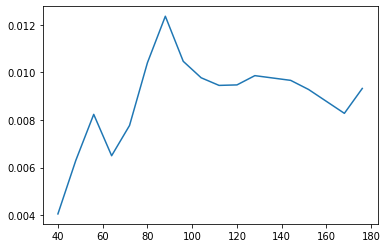

In [18]:
( np.log(cg_times) - np.log(pcg_times) ) / Ns
plt.plot(Ns, ( np.log(cg_times) - np.log(pcg_times) ) / Ns )